In [65]:
from hossam import load_data
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np
import pandas as pd
from pandas import DataFrame
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, pearsonr, spearmanr, probplot, shapiro, kstest, anderson

from statsmodels.formula.api import ols
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [66]:
origin=pd.read_excel('1사분위수_데이터.xlsx')
df=origin.drop('Unnamed: 0', axis=1)
df.head()

,price,carat,cut,color,clarity,x,y,z,depth,table
0,326,0.23,Ideal,E,SI2,3.95,3.98,2.43,61.5,55.0
1,326,0.21,Premium,E,SI1,3.89,3.84,2.31,59.8,61.0
2,327,0.23,Good,E,VS1,4.05,4.07,2.31,56.9,65.0
3,334,0.29,Premium,I,VS2,4.20,4.23,2.63,62.4,58.0
4,335,0.31,Good,J,SI2,4.34,4.35,2.75,63.3,58.0


In [67]:
def ols_report(tbl, data):
    xnames=[n for n in fit.model.exog_names if n!='const']
    indi_mydata1=data.filter(xnames)
    variables=[]
    for i, v in enumerate(tbl.tables[1].data):
        name=v[0].strip()
        if name not in xnames:
            continue
        j=list(indi_mydata1.columns).index(name)
        vif=variance_inflation_factor(indi_mydata1,j)

        p=float(v[4].strip())
        stars=lambda p: (
            '***' if p<0.001 else
            '**' if p<0.01 else
            '*' if p<0.05 else
            ''
        )

        variables.append({
            '종속변수':yname,
            '독립변수':name,
            'B':v[1].strip(),
            '표준오차':v[2].strip(),
            'Beta':float(fit.params[name])*(data[name].std(ddof=1)/data[yname].std(ddof=1)),
            't':'%s%s'%(v[3].strip(), stars(p)),
            'p-value':p,
            '공차':1/vif,
            'vif':vif
        })

    rdf=DataFrame(variables)

    if rdf.empty:
        return None, "데이터 없음", "모델 유의하지 않음", []

    result_dict={}
    for i in [0,2]:
        for item in tbl.tables[i].data:
            n=len(item)
            for j in range(0, n, 2):
                key=item[j].strip()[:-1]
                value=item[j+1].strip()
                if not key or not value:
                    continue
                result_dict[key]=value
    
    result_report=f'R({result_dict['R-squared']}), R²({result_dict['Adj. R-squared']}), F({result_dict['F-statistic']}), 유의확률({result_dict['Prob (F-statistic)']}), Durbin-Watson({result_dict['Durbin-Watson']})'

    tpl='%s에 대하여 %s로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 %s(F(%s,%s)=%s, p %s 0.05).'
    model_report=tpl%(
        rdf['종속변수'][0],
        ','.join(list(rdf['독립변수'])),
        '유의하다' if float(result_dict['Prob (F-statistic)'])<=0.05 else '유의하지 않다',
        result_dict['Df Model'],
        result_dict['Df Residuals'],
        result_dict['F-statistic'],
        '<=' if float(result_dict['Prob (F-statistic)'])<=0.05 else '>'
    )

    variable_reports=[]
    s='%s의 회귀계수는 %s(p %s 0.05)로, %s에 대하여 %s 예측변인인 것으로 나타났다.'

    for i in rdf.index:
        row=rdf.iloc[i]
        variable_reports.append(s%(row['독립변수'],
                                   row['B'],
                                   '<=' if float(row['p-value'])<0.05 else '>',
                                   row['종속변수'],
                                   '유의미한' if float(row['p-value'])<0.05 else '유의하지 않은'))
        
    return rdf, result_report, model_report, variable_reports

In [68]:
mydata=df
yname='price'
# mydata1=mydata.copy()

mydata1=mydata.drop(['cut','color','clarity'], axis=1)
x=mydata1.drop(yname, axis=1)
y=mydata1[yname]
x_input=sm.add_constant(x)
fit=sm.OLS(y, x_input).fit()
tbl1=fit.summary()
rdf, r, m, v=ols_report(tbl1, mydata1)
print('=== 1차 회귀분석 ===')
display(rdf)

=== 1차 회귀분석 ===


,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,444.1770,166.249,0.147601,2.672**,0.008,0.000581,1720.426507
1,price,x,709.1520,35.631,1.044707,19.903***,0.000,0.000079,12600.269404
2,price,y,-1274.4053,54.218,-1.875384,-23.505***,0.000,0.000073,13790.144002
3,price,z,1274.1811,97.471,1.195501,13.072***,0.000,0.000040,25139.452856
4,price,depth,-65.5602,4.743,-0.505297,-13.822***,0.000,0.000108,9297.284914
5,price,table,-8.0945,0.640,-0.113041,-12.655***,0.000,0.001123,890.412640


> vif 값이 가장 높은 z를 제외하고 다시 분석

In [69]:
mydata=df
yname='price'
# mydata1=mydata.copy()

mydata1=mydata.drop(['z','cut','color','clarity'], axis=1)
x=mydata1.drop(yname, axis=1)
y=mydata1[yname]
x_input=sm.add_constant(x)
fit=sm.OLS(y, x_input).fit()
tbl1=fit.summary()
rdf, r, m, v=ols_report(tbl1, mydata1)
print('=== 2차 회귀분석 ===')
display(rdf)

=== 2차 회귀분석 ===


,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,453.9463,167.295,0.150847,2.713**,0.007,0.002664,375.308137
1,price,x,936.4312,31.297,1.379529,29.921***,0.000,0.000079,12599.656621
2,price,y,-715.3252,33.534,-1.052655,-21.331***,0.000,0.000087,11538.544785
3,price,depth,-7.7308,1.722,-0.059584,-4.489***,0.000,0.000990,1009.767085
4,price,table,-7.5902,0.642,-0.105999,-11.814***,0.000,0.001543,648.288709


> vif 값이 가장 높은 x를 제외하고 다시 분석

In [70]:
mydata=df
yname='price'
# mydata1=mydata.copy()

mydata1=mydata.filter(['price','carat','y','depth','table'])
x=mydata1.drop(yname, axis=1)
y=mydata1[yname]
x_input=sm.add_constant(x)
fit=sm.OLS(y, x_input).fit()
tbl1=fit.summary()
rdf, r, m, v=ols_report(tbl1, mydata1)
print('=== 3차 회귀분석 ===')
display(rdf)

=== 3차 회귀분석 ===


,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,3181.2862,144.874,1.057147,21.959***,0.0,0.002960,337.854194
1,price,y,-405.1041,32.935,-0.596141,-12.300***,0.0,0.000375,2668.644544
2,price,depth,-27.9663,1.636,-0.215547,-17.098***,0.0,0.001031,970.297626
3,price,table,-10.6851,0.655,-0.149219,-16.317***,0.0,0.001624,615.655038


> vif 값이 가장 높은 y를 제외하고 다시 분석

In [71]:
mydata=df
yname='price'
# mydata1=mydata.copy()

mydata1=mydata.filter(['price','carat','depth','table'])
x=mydata1.drop(yname, axis=1)
y=mydata1[yname]
x_input=sm.add_constant(x)
fit=sm.OLS(y, x_input).fit()
tbl1=fit.summary()
rdf, r, m, v=ols_report(tbl1, mydata1)
print('=== 4차 회귀분석 ===')
display(rdf)

=== 4차 회귀분석 ===


,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,1421.3183,22.814,0.472307,62.302***,0.0,0.021989,45.477151
1,price,depth,-12.5973,1.061,-0.097092,-11.868***,0.0,0.002069,483.440196
2,price,table,-6.9856,0.585,-0.097556,-11.942***,0.0,0.002191,456.357373


> vif 값이 가장 높은 depth를 제외하고 다시 분석

In [72]:
mydata=df
yname='price'
# mydata1=mydata.copy()

mydata1=mydata.filter(['price','carat','table'])
x=mydata1.drop(yname, axis=1)
y=mydata1[yname]
x_input=sm.add_constant(x)
fit=sm.OLS(y, x_input).fit()
tbl1=fit.summary()
rdf, r, m, v=ols_report(tbl1, mydata1)
print('=== 5차 회귀분석 ===')
display(rdf)

=== 5차 회귀분석 ===


,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,1405.8057,22.894,0.467152,61.404***,0.0,0.023381,42.769264
1,price,table,-4.3737,0.545,-0.061079,-8.028***,0.0,0.023381,42.769264


> carat과 table 모두 vif값은 동일하나, carat의 t값이 더 크기에 table을 제거 후 다시 분석

In [73]:
mydata=df
yname='price'
# mydata1=mydata.copy()

mydata1=mydata.filter(['price','carat'])
x=mydata1.drop(yname, axis=1)
y=mydata1[yname]
x_input=sm.add_constant(x)
fit=sm.OLS(y, x_input).fit()
tbl1=fit.summary()
print('=== 6차 회귀분석 ===')
display(tbl1)

=== 6차 회귀분석 ===


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     3757.
Date:                Tue, 13 Jan 2026   Prob (F-statistic):               0.00
Time:                        17:04:01   Log-Likelihood:                -84717.
No. Observations:               13442   AIC:                         1.694e+05
Df Residuals:                   13440   BIC:                         1.695e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        222.5249      7.676     28.988      0.000     207.478     237.572
carat       1406.5086     22.948     61.291      0.000    1361.527    1451.490
==============================================================================
Omnibus:                      778.110   Durbin-Watson:                   0.199
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              299.391
Skew:                           0.073   Prob(JB):                     9.73e-66
Kurtosis:                       2.284   Cond. No.                         22.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> 명목형 변수들을 다시 넣은 후 회귀분석 진행

In [74]:
mydata=df
yname='price'
# mydata1=mydata.copy()

mydata1=mydata.filter(['price','carat','cut','color','clarity'])
mydata2=pd.get_dummies(mydata1, drop_first=True)
mydata2=mydata2.astype(float)
x=mydata2.drop(yname, axis=1)
y=mydata2[yname]
x_input=sm.add_constant(x)
fit=sm.OLS(y, x_input).fit()
tbl1=fit.summary()
rdf, r, m, v=ols_report(tbl1, mydata2)
print('=== 7차 회귀분석 ===')
display(rdf)

=== 7차 회귀분석 ===


,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,2371.4602,16.394,0.788041,144.653***,0.000,0.022888,43.691027
1,price,cut_Good,-0.6685,9.334,-0.001203,-0.072,0.943,0.093724,10.669682
2,price,cut_Ideal,55.2376,9.059,0.184443,6.098***,0.000,0.016901,59.166387
3,price,cut_Premium,85.1480,9.120,0.234416,9.337***,0.000,0.036214,27.613708
4,price,cut_Very Good,1.7363,9.121,0.004908,0.190,0.849,0.033608,29.755007
5,price,color_E,-28.8032,2.493,-0.078121,-11.555***,0.000,0.396264,2.523567
6,price,color_F,-50.0840,2.635,-0.125428,-19.007***,0.000,0.436412,2.291415
7,price,color_G,-84.5739,2.539,-0.233010,-33.310***,0.000,0.363134,2.753802
8,price,color_H,-139.4901,2.729,-0.333000,-51.116***,0.000,0.454144,2.201946
9,price,color_I,-206.7936,3.162,-0.392261,-65.408***,0.000,0.573758,1.742895


> cut_Good과 cut_Very Good의 p-value 값이 0.05보다 크기 때문에 제거 후 다시 분석

In [75]:
mydata=df
yname='price'
# mydata1=mydata.copy()

mydata1=mydata.filter(['price','carat','cut','color','clarity'])
mydata2=pd.get_dummies(mydata1, drop_first=True)
mydata2=mydata2.astype(float)
mydata3=mydata2.drop(['cut_Good', 'cut_Very Good'], axis=1)
x=mydata3.drop(yname, axis=1)
y=mydata3[yname]
x_input=sm.add_constant(x)
fit=sm.OLS(y, x_input).fit()
tbl1=fit.summary()
rdf, r, m, v=ols_report(tbl1, mydata3)
print('=== 8차 회귀분석 ===')
display(rdf)

=== 8차 회귀분석 ===


,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,2370.8909,16.341,0.787851,145.086***,0.0,0.024165,41.382970
1,price,cut_Ideal,54.1239,1.661,0.180725,32.579***,0.0,0.392225,2.549555
2,price,cut_Premium,84.0590,2.007,0.231418,41.883***,0.0,0.582772,1.715938
3,price,color_E,-28.8034,2.492,-0.078121,-11.557***,0.0,0.396846,2.519871
4,price,color_F,-50.1017,2.634,-0.125472,-19.022***,0.0,0.436623,2.290308
5,price,color_G,-84.5644,2.539,-0.232984,-33.308***,0.0,0.363283,2.752673
6,price,color_H,-139.5255,2.728,-0.333084,-51.140***,0.0,0.454639,2.199547
7,price,color_I,-206.8512,3.161,-0.392370,-65.448***,0.0,0.574076,1.741929
8,price,color_J,-276.0162,4.559,-0.323616,-60.544***,0.0,0.768002,1.302080
9,price,clarity_IF,551.0483,11.957,0.770026,46.086***,0.0,0.355717,2.811226


📕 선형성 검정
RESET F-statistic: 14.2519
p-value: 0.0002
선형성/기능형 위배 가능성이 있음 (5% 유의수준)


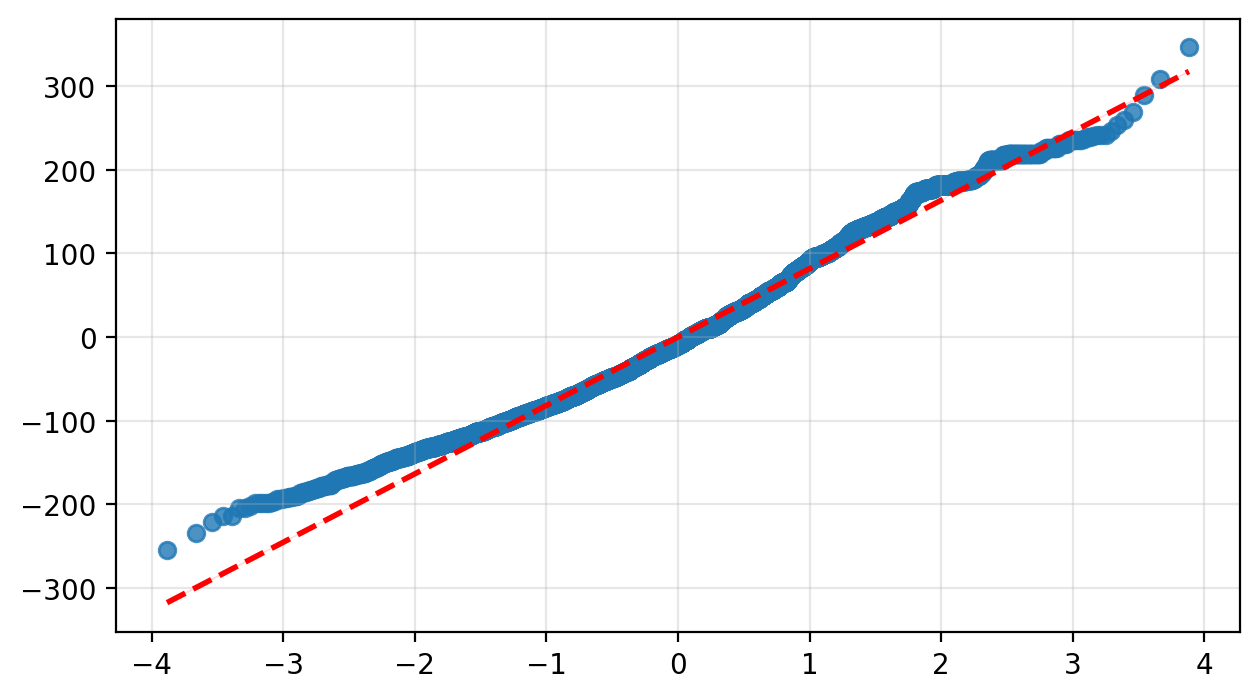

루트 1MSE 구간에 포함된 잔차 비율: 66.29%
루트 2MSE 구간에 포함된 잔차 비율: 95.51%
루트 3MSE 구간에 포함된 잔차 비율: 99.95%


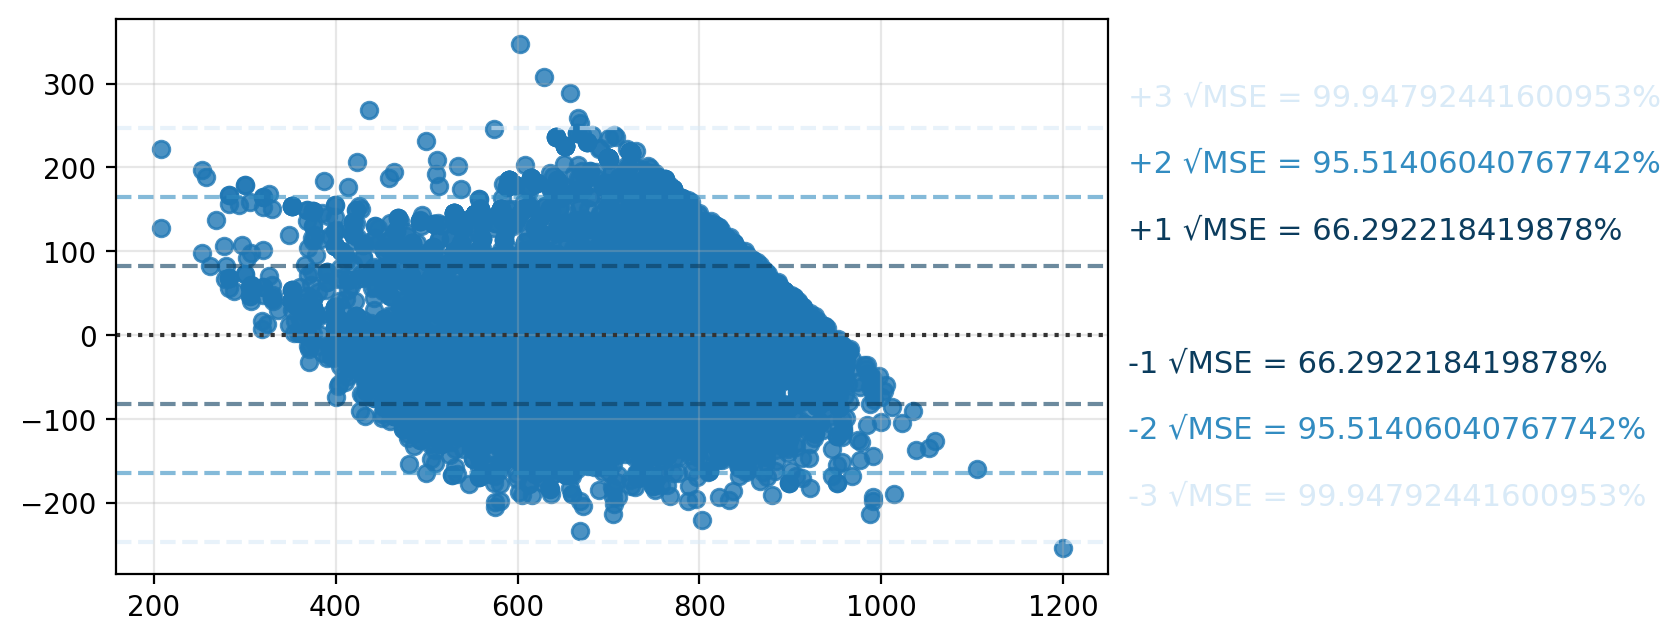

🎯 잔차의 정규성, 등분산성, 독립성 검정
Anderson-Darling statistic: 60.7238, 5% 임계값: 0.7870
정규성 가정 위배 가능성이 있음 (5% 유의수준)
Breusch-Pagan statistic: 22.402, p-value = 0.000
이분산성 존재(등분산 아님)
Durbin-Watson=0.575
잔차에 양(+)의 자기상관이 존재할 가능성 있음 (독립성 위반)
🎓 최종 결과 보고
price에 대하여 carat,cut_Ideal,cut_Premium,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(16,13425)=1923., p <= 0.05).
carat의 회귀계수는 2370.8909(p <= 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
cut_Ideal의 회귀계수는 54.1239(p <= 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
cut_Premium의 회귀계수는 84.0590(p <= 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_E의 회귀계수는 -28.8034(p <= 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_F의 회귀계수는 -50.1017(p <= 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_G의 회귀계수는 -84.5644(p <= 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_H의 회귀계수는 -139.5255(p <= 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_I의 회귀계수는 -206.8512(p <= 0.05)

In [76]:
# 잔차 검정
print('='*50)
print('📕 선형성 검정')
print('='*50)
reset_res=linear_reset(fit, power=2, use_f=True)
print(f'RESET F-statistic: {reset_res.fvalue:.4f}')
print(f'p-value: {reset_res.pvalue:.4f}')
if reset_res.pvalue<0.05:
    print('선형성/기능형 위배 가능성이 있음 (5% 유의수준)')
else:
    print('선형성 가정 위배 근거 없음 (5% 유의수준)')

(x,y),_=probplot(fit.resid)
width_px=1280
height_px=720
rows=1
cols=1
figsize=(width_px/my_dpi, height_px/my_dpi)
fig, ax=plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)
sb.regplot(x=x, y=y, line_kws={'color':'red', 'linestyle':'--', 'linewidth':2})
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

rr=fit.resid
mse_sq=fit.mse_resid
mse_root=np.sqrt(mse_sq)
colors=['#0B3C5D', '#328CC1', '#D9EAF7']
r1=rr[(rr>-mse_root)&(rr<mse_root)].count()/rr.count()*100
r2=rr[(rr>-2*mse_root)&(rr<2*mse_root)].count()/rr.count()*100
r3=rr[(rr>-3*mse_root)&(rr<3*mse_root)].count()/rr.count()*100
mse_r=[r1,r2,r3]
print(f'루트 1MSE 구간에 포함된 잔차 비율: {r1:.2f}%')
print(f'루트 2MSE 구간에 포함된 잔차 비율: {r2:.2f}%')
print(f'루트 3MSE 구간에 포함된 잔차 비율: {r3:.2f}%')
width_px=1280
height_px=720
rows=1
cols=1
figsize=(width_px/my_dpi, height_px/my_dpi)
fig, ax=plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)
sb.residplot(x=fit.fittedvalues, y=fit.resid)
ax.grid(True, alpha=0.3)
for i, c in enumerate(colors):
    k=i+1
    y_pos=k*mse_root
    ax.axhline(y=y_pos, color=c, linestyle='--', alpha=0.6)
    ax.axhline(y=-y_pos, color=c, linestyle='--', alpha=0.6)
    ax.text(x=1.02, y=0.5+0.12*k,
            s=f'+{k} √MSE = {mse_r[i]}%',
            transform=ax.transAxes,
            ha='left', va='center', fontsize=11, color=c)
    ax.text(x=1.02, y=0.5-0.12*k,
            s=f'-{k} √MSE = {mse_r[i]}%',
            transform=ax.transAxes,
            ha='left', va='center', fontsize=11, color=c)
plt.show()
plt.close()

# 잔차의 정규성, 등분산성, 독립성 검정
print('='*50)
print('🎯 잔차의 정규성, 등분산성, 독립성 검정')
print('='*50)
if len(origin)<5000:
    method='Shapiro-Wilk'
    s, p=shapiro(fit.resid)
    print(f'{method} statistic: {s:.4f}, p-value: {p:.4f}')
    violated=p<0.05
else:
    method='Anderson-Darling'
    ad_res=anderson(fit.resid, dist='norm')
    crit_levels=ad_res.significance_level.tolist()
    crit_values=ad_res.critical_values.tolist()
    crit_5=crit_values[crit_levels.index(5.0)] if 5.0 in crit_levels else None
    print(f'{method} statistic: {ad_res.statistic:.4f}, 5% 임계값: {crit_5:.4f}')
    violated=crit_5 is not None and ad_res.statistic>crit_5
print('정규성 가정 위배 가능성이 있음 (5% 유의수준)' if violated else '정규성 가정 위배 근거 없음 (5% 유의수준)')

names=['LM Statistic', 'LM p-value', 'F Statistic', 'F p-value']
bp_test=het_breuschpagan(fit.resid, fit.model.exog)
bp=DataFrame(bp_test, index=names, columns=['value'])
p_bp=bp.loc['F p-value', 'value']
print(f'Breusch-Pagan statistic: {bp.loc['F Statistic', 'value']:.3f}, p-value = {p_bp:.3f}')
print(f'{'이분산성 존재(등분산 아님)' if p_bp<=0.05 else '등분산성 만족'}')

dw=durbin_watson(fit.resid)
if 1.5<=dw<=2.5:
    interpretation='잔차는 독립성을 만족함 (자기상관 없음)'
elif dw<1.5:
    interpretation='잔차에 양(+)의 자기상관이 존재할 가능성 있음 (독립성 위반)'
else:
    interpretation='잔차에 음(-)의 자기상관이 존재할 가능성 있음 (독립성 위반)'
print(f'Durbin-Watson={dw:.3f}\n{interpretation}')

# 최종 결과 보고
print('='*50)
print('🎓 최종 결과 보고')
print('='*50)
print(m)
print('\n'.join(v))

In [77]:
r

'R(0.696), R²(0.696), F(1923.), 유의확률(0.00), Durbin-Watson(0.575)'

# 아래는 참고용

⭐⭐⭐ 아래는 더미변수 모두 넣고 vif, p-value 이상치만 제거한 회귀분석 ⭐⭐⭐

In [78]:
mydata=df
yname='price'
mydata1=mydata.copy()

mydata2=pd.get_dummies(mydata1, drop_first=True)
mydata2=mydata2.astype(float)
x=mydata2.drop(yname, axis=1)
y=mydata2[yname]
x_input=sm.add_constant(x)
fit=sm.OLS(y, x_input).fit()
tbl1=fit.summary()
rdf, r, m, v=ols_report(tbl1, mydata2)
print('=== 1차 회귀분석 ===')
display(rdf)
count=2

while True:
    if rdf['vif'].max()>=10:
        mydata2=mydata2.drop(rdf[rdf['vif']==rdf['vif'].max()]['독립변수'], axis=1)
        x=mydata2.drop(yname, axis=1)
        y=mydata2[yname]
        x_input=sm.add_constant(x)
        fit=sm.OLS(y, x_input).fit()
        tbl=fit.summary()
        rdf, r, m, v=ols_report(tbl, mydata2)
        print('=== %s차 회귀분석 ==='%count)
        display(rdf)
        count+=1
    else:
        print('***'*30)
        print('*** vif 10 이상 제거 완료 ***')
        print('***'*30)
        break

print('#'*50)
print('p-value 무효값을 제외한 최종 모델')
print('#'*50)
# p-value 무효값 제외
xnames=list(rdf[rdf['p-value']>0.05]['독립변수'])
mydata2=mydata2.drop(xnames, axis=1)
x=mydata2.drop(yname, axis=1)
y=mydata2[yname]
x_input=sm.add_constant(x)
fit=sm.OLS(y, x_input).fit()
tbl=fit.summary()
rdf, r, m, v=ols_report(tbl, mydata2)
display(rdf)

=== 1차 회귀분석 ===


,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,1711.4121,89.899,0.568705,19.037***,0.000,0.000541,1847.239398
1,price,x,880.4463,19.040,1.297053,46.242***,0.000,0.000071,14047.832248
2,price,y,-1899.1972,30.374,-2.794812,-62.528***,0.000,0.000058,17371.042684
3,price,z,1934.3544,52.438,1.814909,36.889***,0.000,0.000037,26761.603670
4,price,depth,-77.9667,2.579,-0.600919,-30.230***,0.000,0.000100,10020.551006
5,price,table,-0.5895,0.413,-0.008232,-1.427,0.154,0.000709,1410.540659
6,price,cut_Good,84.6566,7.597,0.152378,11.143***,0.000,0.071465,13.992915
7,price,cut_Ideal,133.5999,7.547,0.446102,17.703***,0.000,0.012162,82.225755
8,price,cut_Premium,139.2064,7.444,0.383241,18.701***,0.000,0.027046,36.973728
9,price,cut_Very Good,100.2807,7.490,0.283480,13.388***,0.000,0.024785,40.347492


=== 2차 회귀분석 ===


,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,1664.5585,94.335,0.553136,17.645***,0.000,0.001659,602.800585
1,price,x,1190.7095,17.926,1.754126,66.423***,0.000,0.000071,14028.880836
2,price,y,-1008.1101,19.324,-1.483510,-52.170***,0.000,0.000072,13904.980589
3,price,depth,10.4978,0.996,0.080911,10.541***,0.000,0.000856,1167.605146
4,price,table,-0.1532,0.433,-0.002139,-0.353,0.724,0.000946,1056.715631
5,price,cut_Good,61.1770,7.945,0.110116,7.700***,0.000,0.071938,13.900839
6,price,cut_Ideal,116.2600,7.904,0.388202,14.708***,0.000,0.012346,81.000126
7,price,cut_Premium,128.4210,7.806,0.353548,16.452***,0.000,0.027248,36.700429
8,price,cut_Very Good,78.2517,7.836,0.221207,9.986***,0.000,0.025136,39.783380
9,price,color_E,-29.1084,2.093,-0.078948,-13.906***,0.000,0.392408,2.548368


=== 3차 회귀분석 ===


,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,4880.8791,93.321,1.621925,52.302***,0.000,0.001777,562.761175
1,price,y,-571.1978,20.944,-0.840561,-27.273***,0.000,0.000235,4260.118548
2,price,depth,-13.3471,1.071,-0.102871,-12.465***,0.000,0.000913,1095.522943
3,price,table,-4.8059,0.493,-0.067115,-9.749***,0.000,0.000977,1023.822693
4,price,cut_Good,31.1568,9.143,0.056081,3.408**,0.001,0.072089,13.871722
5,price,cut_Ideal,90.4021,9.100,0.301861,9.934***,0.000,0.012346,81.000125
6,price,cut_Premium,118.8659,8.996,0.327243,13.213***,0.000,0.027259,36.685135
7,price,cut_Very Good,38.0540,9.005,0.107574,4.226***,0.000,0.025180,39.714082
8,price,color_E,-29.0655,2.413,-0.078832,-12.046***,0.000,0.392459,2.548036
9,price,color_F,-50.2169,2.550,-0.125761,-19.694***,0.000,0.432271,2.313362


=== 4차 회귀분석 ===


,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,2372.8113,16.299,0.788490,145.584***,0.000,0.017109,58.449960
1,price,depth,8.2832,0.739,0.063842,11.207***,0.000,0.001212,825.098160
2,price,table,-0.3784,0.478,-0.005284,-0.791,0.429,0.001453,688.170497
3,price,cut_Good,4.9569,9.341,0.008922,0.531,0.596,0.076390,13.090760
4,price,cut_Ideal,69.8625,9.317,0.233277,7.499***,0.000,0.014041,71.219031
5,price,cut_Premium,104.9394,9.227,0.288903,11.373***,0.000,0.029305,34.123391
6,price,cut_Very Good,16.9512,9.217,0.047919,1.839,0.066,0.027429,36.457478
7,price,color_E,-28.1266,2.478,-0.076286,-11.349***,0.000,0.392542,2.547500
8,price,color_F,-49.6962,2.619,-0.124457,-18.972***,0.000,0.432592,2.311647
9,price,color_G,-85.0929,2.524,-0.234440,-33.712***,0.000,0.362359,2.759696


=== 5차 회귀분석 ===


,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,2370.0904,16.372,0.787585,144.763***,0.000,0.018189,54.979365
1,price,table,-2.7130,0.432,-0.037887,-6.274***,0.000,0.003130,319.467564
2,price,cut_Good,-4.7584,9.343,-0.008565,-0.509,0.611,0.080582,12.409677
3,price,cut_Ideal,47.1902,9.136,0.157572,5.165***,0.000,0.014842,67.374387
4,price,cut_Premium,85.6534,9.107,0.235807,9.405***,0.000,0.029800,33.556672
5,price,cut_Very Good,-1.0131,9.118,-0.002864,-0.111,0.912,0.028350,35.273898
6,price,color_E,-28.4578,2.490,-0.077184,-11.430***,0.000,0.392737,2.546232
7,price,color_F,-50.0970,2.631,-0.125461,-19.039***,0.000,0.433292,2.307915
8,price,color_G,-84.8220,2.536,-0.233693,-33.451***,0.000,0.362831,2.756104
9,price,color_H,-139.8641,2.726,-0.333893,-51.314***,0.000,0.453910,2.203080


=== 6차 회귀분석 ===


,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,2371.4602,16.394,0.788041,144.653***,0.000,0.022888,43.691027
1,price,cut_Good,-0.6685,9.334,-0.001203,-0.072,0.943,0.093724,10.669682
2,price,cut_Ideal,55.2376,9.059,0.184443,6.098***,0.000,0.016901,59.166387
3,price,cut_Premium,85.1480,9.120,0.234416,9.337***,0.000,0.036214,27.613708
4,price,cut_Very Good,1.7363,9.121,0.004908,0.190,0.849,0.033608,29.755007
5,price,color_E,-28.8032,2.493,-0.078121,-11.555***,0.000,0.396264,2.523567
6,price,color_F,-50.0840,2.635,-0.125428,-19.007***,0.000,0.436412,2.291415
7,price,color_G,-84.5739,2.539,-0.233010,-33.310***,0.000,0.363134,2.753802
8,price,color_H,-139.4901,2.729,-0.333000,-51.116***,0.000,0.454144,2.201946
9,price,color_I,-206.7936,3.162,-0.392261,-65.408***,0.000,0.573758,1.742895


=== 7차 회귀분석 ===


,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,2365.2125,16.384,0.785965,144.360***,0.0,0.024250,41.236460
1,price,cut_Good,-55.0131,2.777,-0.099021,-19.811***,0.0,0.838871,1.192078
2,price,cut_Premium,30.7313,1.880,0.084604,16.343***,0.0,0.667404,1.498342
3,price,cut_Very Good,-52.7573,1.826,-0.149138,-28.895***,0.0,0.657025,1.522011
4,price,color_E,-29.0762,2.496,-0.078861,-11.651***,0.0,0.396650,2.521117
5,price,color_F,-50.6102,2.637,-0.126746,-19.191***,0.0,0.436517,2.290863
6,price,color_G,-84.6457,2.542,-0.233208,-33.293***,0.0,0.363247,2.752947
7,price,color_H,-139.4210,2.733,-0.332835,-51.023***,0.0,0.454445,2.200488
8,price,color_I,-206.6796,3.166,-0.392045,-65.285***,0.0,0.573770,1.742858
9,price,color_J,-275.9484,4.566,-0.323537,-60.434***,0.0,0.767878,1.302290


=== 8차 회귀분석 ===


,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,cut_Good,-60.2550,4.436,-0.108456,-13.584***,0.000,0.839082,1.191778
1,price,cut_Premium,21.3315,3.002,0.058727,7.105***,0.000,0.667427,1.498292
2,price,cut_Very Good,-71.5318,2.909,-0.202211,-24.586***,0.000,0.658026,1.519698
3,price,color_E,-18.8975,3.985,-0.051254,-4.742***,0.000,0.400703,2.495614
4,price,color_F,-27.6267,4.205,-0.069187,-6.569***,0.000,0.444704,2.248685
5,price,color_G,-40.7864,4.033,-0.112371,-10.114***,0.000,0.374605,2.669479
6,price,color_H,-102.7943,4.347,-0.245397,-23.650***,0.000,0.463881,2.155725
7,price,color_I,-139.6328,5.003,-0.264866,-27.910***,0.000,0.591910,1.689447
8,price,color_J,-156.3792,7.174,-0.183347,-21.799***,0.000,0.796799,1.255022
9,price,clarity_IF,176.5621,18.612,0.246725,9.487***,0.000,0.704826,1.418790


******************************************************************************************
*** vif 10 이상 제거 완료 ***
******************************************************************************************
##################################################
p-value 무효값을 제외한 최종 모델
##################################################


,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,cut_Good,-60.2559,4.436,-0.108458,-13.584***,0.0,0.879914,1.136475
1,price,cut_Premium,21.3296,3.002,0.058721,7.105***,0.0,0.715582,1.397465
2,price,cut_Very Good,-71.5262,2.909,-0.202195,-24.590***,0.0,0.710376,1.407705
3,price,color_E,-18.9039,3.985,-0.051272,-4.744***,0.0,0.589539,1.696240
4,price,color_F,-27.6426,4.202,-0.069227,-6.579***,0.0,0.615229,1.625412
5,price,color_G,-40.7931,4.032,-0.112389,-10.118***,0.0,0.536007,1.865646
6,price,color_H,-102.7971,4.346,-0.245404,-23.652***,0.0,0.634925,1.574989
7,price,color_I,-139.6320,5.003,-0.264864,-27.911***,0.0,0.749326,1.334533
8,price,color_J,-156.3836,7.173,-0.183353,-21.801***,0.0,0.877669,1.139382
9,price,clarity_IF,174.9247,6.019,0.244437,29.060***,0.0,0.822327,1.216062


📕 선형성 검정
RESET F-statistic: 68.3422
p-value: 0.0000
선형성/기능형 위배 가능성이 있음 (5% 유의수준)


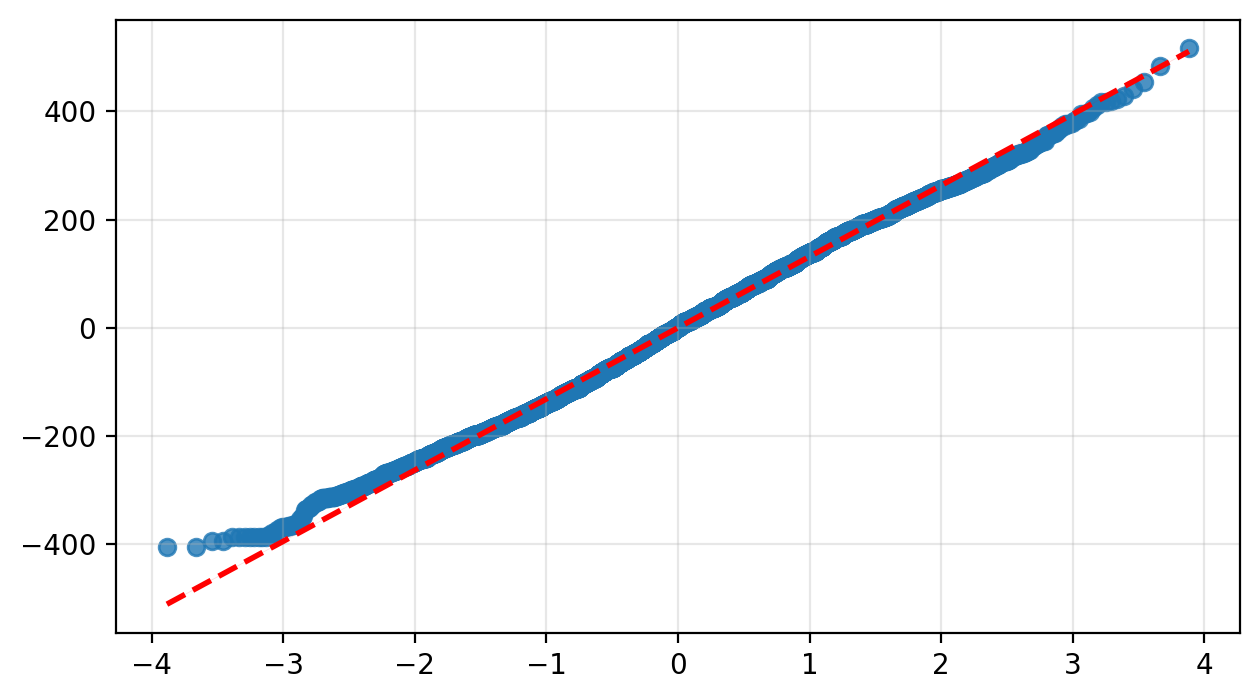

루트 1MSE 구간에 포함된 잔차 비율: 65.36%
루트 2MSE 구간에 포함된 잔차 비율: 96.66%
루트 3MSE 구간에 포함된 잔차 비율: 99.89%


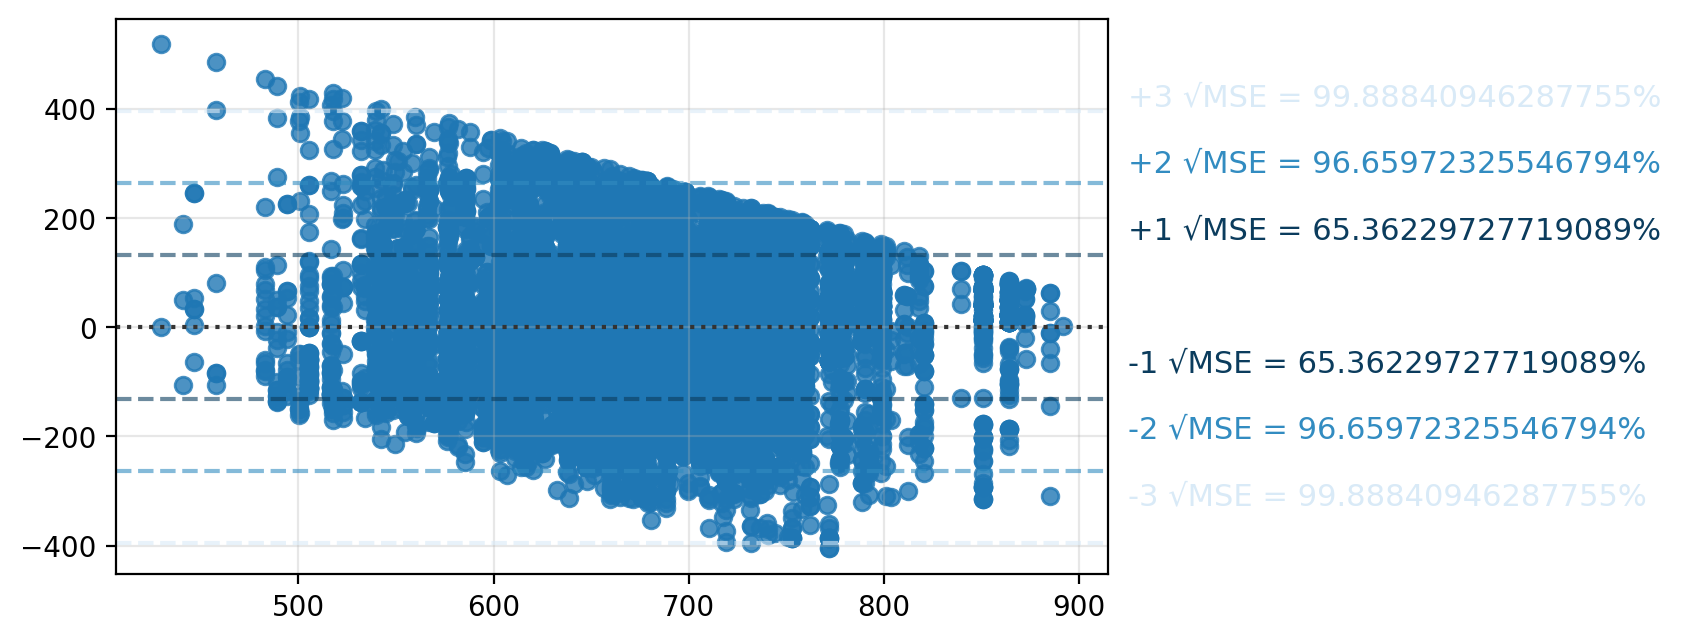

🎯 잔차의 정규성, 등분산성, 독립성 검정
Anderson-Darling statistic: 11.2275, 5% 임계값: 0.7870
정규성 가정 위배 가능성이 있음 (5% 유의수준)
Breusch-Pagan statistic: 27.162, p-value = 0.000
이분산성 존재(등분산 아님)
Durbin-Watson=0.268
잔차에 양(+)의 자기상관이 존재할 가능성 있음 (독립성 위반)
🎓 최종 결과 보고
price에 대하여 cut_Good,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(15,13426)=256.2, p <= 0.05).
cut_Good의 회귀계수는 -60.2559(p <= 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
cut_Premium의 회귀계수는 21.3296(p <= 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
cut_Very Good의 회귀계수는 -71.5262(p <= 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_E의 회귀계수는 -18.9039(p <= 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_F의 회귀계수는 -27.6426(p <= 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_G의 회귀계수는 -40.7931(p <= 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_H의 회귀계수는 -102.7971(p <= 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_I의 회귀계수는 -139.6320(p <= 0.0

In [79]:
# 잔차 검정
print('='*50)
print('📕 선형성 검정')
print('='*50)
reset_res=linear_reset(fit, power=2, use_f=True)
print(f'RESET F-statistic: {reset_res.fvalue:.4f}')
print(f'p-value: {reset_res.pvalue:.4f}')
if reset_res.pvalue<0.05:
    print('선형성/기능형 위배 가능성이 있음 (5% 유의수준)')
else:
    print('선형성 가정 위배 근거 없음 (5% 유의수준)')

(x,y),_=probplot(fit.resid)
width_px=1280
height_px=720
rows=1
cols=1
figsize=(width_px/my_dpi, height_px/my_dpi)
fig, ax=plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)
sb.regplot(x=x, y=y, line_kws={'color':'red', 'linestyle':'--', 'linewidth':2})
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

rr=fit.resid
mse_sq=fit.mse_resid
mse_root=np.sqrt(mse_sq)
colors=['#0B3C5D', '#328CC1', '#D9EAF7']
r1=rr[(rr>-mse_root)&(rr<mse_root)].count()/rr.count()*100
r2=rr[(rr>-2*mse_root)&(rr<2*mse_root)].count()/rr.count()*100
r3=rr[(rr>-3*mse_root)&(rr<3*mse_root)].count()/rr.count()*100
mse_r=[r1,r2,r3]
print(f'루트 1MSE 구간에 포함된 잔차 비율: {r1:.2f}%')
print(f'루트 2MSE 구간에 포함된 잔차 비율: {r2:.2f}%')
print(f'루트 3MSE 구간에 포함된 잔차 비율: {r3:.2f}%')
width_px=1280
height_px=720
rows=1
cols=1
figsize=(width_px/my_dpi, height_px/my_dpi)
fig, ax=plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)
sb.residplot(x=fit.fittedvalues, y=fit.resid)
ax.grid(True, alpha=0.3)
for i, c in enumerate(colors):
    k=i+1
    y_pos=k*mse_root
    ax.axhline(y=y_pos, color=c, linestyle='--', alpha=0.6)
    ax.axhline(y=-y_pos, color=c, linestyle='--', alpha=0.6)
    ax.text(x=1.02, y=0.5+0.12*k,
            s=f'+{k} √MSE = {mse_r[i]}%',
            transform=ax.transAxes,
            ha='left', va='center', fontsize=11, color=c)
    ax.text(x=1.02, y=0.5-0.12*k,
            s=f'-{k} √MSE = {mse_r[i]}%',
            transform=ax.transAxes,
            ha='left', va='center', fontsize=11, color=c)
plt.show()
plt.close()

# 잔차의 정규성, 등분산성, 독립성 검정
print('='*50)
print('🎯 잔차의 정규성, 등분산성, 독립성 검정')
print('='*50)
if len(origin)<5000:
    method='Shapiro-Wilk'
    s, p=shapiro(fit.resid)
    print(f'{method} statistic: {s:.4f}, p-value: {p:.4f}')
    violated=p<0.05
else:
    method='Anderson-Darling'
    ad_res=anderson(fit.resid, dist='norm')
    crit_levels=ad_res.significance_level.tolist()
    crit_values=ad_res.critical_values.tolist()
    crit_5=crit_values[crit_levels.index(5.0)] if 5.0 in crit_levels else None
    print(f'{method} statistic: {ad_res.statistic:.4f}, 5% 임계값: {crit_5:.4f}')
    violated=crit_5 is not None and ad_res.statistic>crit_5
print('정규성 가정 위배 가능성이 있음 (5% 유의수준)' if violated else '정규성 가정 위배 근거 없음 (5% 유의수준)')

names=['LM Statistic', 'LM p-value', 'F Statistic', 'F p-value']
bp_test=het_breuschpagan(fit.resid, fit.model.exog)
bp=DataFrame(bp_test, index=names, columns=['value'])
p_bp=bp.loc['F p-value', 'value']
print(f'Breusch-Pagan statistic: {bp.loc['F Statistic', 'value']:.3f}, p-value = {p_bp:.3f}')
print(f'{'이분산성 존재(등분산 아님)' if p_bp<=0.05 else '등분산성 만족'}')

dw=durbin_watson(fit.resid)
if 1.5<=dw<=2.5:
    interpretation='잔차는 독립성을 만족함 (자기상관 없음)'
elif dw<1.5:
    interpretation='잔차에 양(+)의 자기상관이 존재할 가능성 있음 (독립성 위반)'
else:
    interpretation='잔차에 음(-)의 자기상관이 존재할 가능성 있음 (독립성 위반)'
print(f'Durbin-Watson={dw:.3f}\n{interpretation}')

# 최종 결과 보고
print('='*50)
print('🎓 최종 결과 보고')
print('='*50)
print(m)
print('\n'.join(v))

In [80]:
r

'R(0.223), R²(0.222), F(256.2), 유의확률(0.00), Durbin-Watson(0.268)'